In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, defaultdict

In [2]:
# DAG provided in appendix A
dag = {
    (1, 31), (2, 1), (3, 8), (4, 3), (5, 2), (6, 16), (7, 6), (8, 7), (9, 8), (10, 9), (11, 1), (12, 5), (13, 12), (14, 13), (15, 11), (16, 5), (17, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 18), (22, 21), (23, 22), (24, 5), (25, 24), (26, 25), (27, 26), (28, 26), (29, 27), (29, 28), (30, 4), (30, 10), (30, 14), (30, 20), (30, 23), (30, 29)
}
python_dag = {
    (0, 30), (1, 0), (2, 7), (3, 2), (4, 1), (5, 15), (6, 5), (7, 6), (8, 7), (9, 8), (10, 0), (11, 4), (12, 11), (13, 12), (16, 14), (14, 10), (15, 4), (16, 15), (17, 16), (18, 17), (19, 18), (20, 17), (21, 20), (22, 21), (23, 4), (24, 23), (25, 24), (26, 25), (27, 25), (28, 26), (28, 27), (29, 3), (29, 9),
    (29, 13), (29, 19), (29, 22), (29, 28)
}

# processing times provided in Appendix A
p = [3, 10, 2, 2, 5, 2, 14, 5, 6, 5, 5, 2, 3, 3, 5, 6, 6, 6, 2, 3, 2, 3, 14, 5, 18, 10, 2, 3, 6, 2, 10]

test_p = [1, 3, 5]

# due dates provided in Appendix A
d = [172, 82, 18, 61, 93, 71, 217, 295, 290, 287, 253, 307, 279, 73, 355, 34, 233, 77, 88, 122, 71, 181, 340, 141, 209, 217, 256, 144, 307, 329, 269]

test_d = [4, 3, 6]

num_nodes = len(p)

# initial solution for tabu search algorithm for given DAG
initial_solution = [30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]

# LCL Implementation

In [3]:
# Constructs an inverted graph by adjacency list and num_successors from a set of edges.
def build_graph(edges):

    inv_graph = dict()
    num_successors = dict()
    
    for u, v in edges:
        if u not in num_successors:
            num_successors[u] = 0
        if v not in num_successors:
            num_successors[v] = 0

        # Add nodes and edges to the graph
        if v not in inv_graph: inv_graph[v] = []
        inv_graph[v].append(u)
        num_successors[u] += 1
        
    return inv_graph, num_successors

# Calculates the tardiness giving a completion time and due date
def tardiness(C, dd): return max(0, C-dd)
    

# Finds an optimal schedule according to LCL given a graph, processing times, and due dates
def least_cost_last(dag, processing_times, due_dates):

    # build adjacency list and track number of successors
    inv_graph, num_successors = build_graph(dag)

    schedule = []
    total_processing_time = sum(processing_times)
    total_cost = 0

    # Jobs to be scheduled are ones with 0 successors
    ready_to_schedule = {job for job in num_successors if num_successors[job] == 0}
    count = 0
    # While we have jobs to be scheduled left
    while ready_to_schedule:
        count += 1
        # Choose the job with the min tardiness
        last_job = min(ready_to_schedule, key=lambda j: (tardiness(total_processing_time, due_dates[j]), j))

        schedule.append(last_job)
        total_cost = max(total_cost, tardiness(total_processing_time, due_dates[last_job]))
        ready_to_schedule.remove(last_job)
        total_processing_time -= processing_times[last_job]
        
        # If the job is a root in the graph
        if last_job not in inv_graph: continue

        for parent in inv_graph[last_job]:

            # Decrement number of successors because we scheduled the job
            num_successors[parent] -= 1

            # If ready to be scheduled, add to list
            if num_successors[parent] == 0:  
                ready_to_schedule.add(parent)

        if count in {1, 2, 5, 10, 15, 20, 25}:
            print('Iteration number {0}: Schedule is '.format(count), [1 + n for n in schedule[::-1]])
        
    print('Final Schedule is ', [1 + n for n in schedule[::-1]])
    return [1 + n for n in schedule[::-1]], total_cost

In [4]:
schedule, cost = least_cost_last(python_dag, p, d)

Iteration number 1: Schedule is  [31]
Iteration number 2: Schedule is  [1, 31]
Iteration number 5: Schedule is  [2, 15, 11, 1, 31]
Iteration number 10: Schedule is  [25, 24, 13, 12, 5, 2, 15, 11, 1, 31]
Iteration number 15: Schedule is  [14, 29, 28, 27, 26, 25, 24, 13, 12, 5, 2, 15, 11, 1, 31]
Iteration number 20: Schedule is  [8, 7, 6, 17, 16, 14, 29, 28, 27, 26, 25, 24, 13, 12, 5, 2, 15, 11, 1, 31]
Iteration number 25: Schedule is  [20, 19, 18, 10, 9, 8, 7, 6, 17, 16, 14, 29, 28, 27, 26, 25, 24, 13, 12, 5, 2, 15, 11, 1, 31]
Final Schedule is  [30, 4, 3, 23, 22, 21, 20, 19, 18, 10, 9, 8, 7, 6, 17, 16, 14, 29, 28, 27, 26, 25, 24, 13, 12, 5, 2, 15, 11, 1, 31]


# TABU Implementation

In [5]:
# finding all nodes that a given node can reach either directly or transitively
def get_all_reachable(dag):
    reachable = set()
    nodes = list(range(num_nodes))

    # marking all nodes reached from a direct edge as reachable
    for (u, v) in dag:
        reachable.add((u, v))

    # Floyd-Warshall algorithm
    for i in nodes:
        for j in nodes:
            for k in nodes:
                # transitive reachability, i.e. if i can reach j & j can reach k, i can reach k 
                if (i, j) in reachable and (j, k) in reachable:
                    reachable.add((i, k))

    return reachable

reachable = get_all_reachable(dag)

In [15]:
def generate_initial_solution(dag):
    # generating an initial solution using a topical sort
    num_edges_into_node = {}
    all_nodes = set(list(range(1, num_nodes+1)))
    
    # initializing dictionary
    for node in all_nodes:
        num_edges_into_node[node] = 0
    
    for (u, v) in dag:
        num_edges_into_node[v] += 1
        
    # finding all nodes with no edges into it
    processing_queue = deque([node for node in all_nodes if num_edges_into_node[node] == 0])
    initial_solution = []
    while processing_queue:
        node = processing_queue.popleft()
        initial_solution.append(node)
        
        for (u, v) in dag:
            if u == node:
                num_edges_into_node[v] -= 1
                if num_edges_into_node[v] == 0:
                    processing_queue.append(v)
    
    does_contain_cycles = len(initial_solution) != len(all_nodes)
    if not does_contain_cycles:
        return initial_solution
    else:
        return [] # if there is a cycle, no way to do tabu search

In [16]:
# checking if we can swap two nodes at positions i, j in a schedule where i < j
def is_valid_swap(job_i, job_j, reachable=reachable):
    return (job_i, job_j) not in reachable and (job_j, job_i) not in reachable # if either u depends on v or v depends on u, cannot swap nodes

def generate_neighboring_schedule(schedule, tabu_list, swap_index, reachable=reachable):
    neighboring_schedule = []
    step_counter = 0
    
    # random swapping neighbor generation, not restricted to adjacent jobs
    # i_list = list(range(num_nodes))
    # random.shuffle(i_list)
    # j_list = list(range(num_nodes))
    # random.shuffle(j_list)
    # 
    # # shuffle lists so we don't overweight swaps early in schedule
    # for i in i_list:
    #     for j in j_list:
    #         job_i, job_j = schedule[i], schedule[j]
    #         if is_valid_swap(job_i, job_j, reachable) and (job_i, job_j) not in tabu_list:
    #             neighboring_schedule = schedule[:]
    #             neighboring_schedule[i], neighboring_schedule[j] = neighboring_schedule[j], neighboring_schedule[i]
    #             return neighboring_schedule, (job_i, job_j), i
    # 
    
    for step_counter in range(len(schedule)):
        i = (swap_index + step_counter) % (len(schedule) - 1)
        j = (swap_index + step_counter + 1) % (len(schedule) - 1)
        job_i, job_j = schedule[i], schedule[j]
        if is_valid_swap(job_i, job_j, reachable) and (job_i, job_j) not in tabu_list and (job_j, job_i) not in tabu_list:
            neighboring_schedule = schedule[:]
            neighboring_schedule[i], neighboring_schedule[j] = neighboring_schedule[j], neighboring_schedule[i]
            return neighboring_schedule, (job_i, job_j), i
                
    # if no valid neighbors, we are done            
    return neighboring_schedule, (-1, -1), -1

def evaluate_tardiness(schedule, p, d):
    total_tardiness = 0
    current_time = 0
    
    for job in schedule:
        completion_time = current_time + p[job-1] # -1 because 0 indexing
        tardiness = max(0, completion_time - d[job-1])
        total_tardiness += tardiness
        current_time = completion_time
    
    return total_tardiness

def tabu_search(dag, p, d, num_iterations=100, tolerance=10, tabu_list_length=20, use_default_initial_solution=True, verbose=False):
    # initializing parameters
    tabu_list = deque(maxlen=tabu_list_length)
    reachable = get_all_reachable(dag)
    current_schedule = initial_solution if use_default_initial_solution else generate_initial_solution(dag)
    current_tardiness = evaluate_tardiness(current_schedule, p, d)
    best_schedule = current_schedule
    best_tardiness = current_tardiness
    new_swap_index = 0
    swapped_i_for_iteration = set() # keeps track of all swap positions we have seen for a given iteration, if we see a repeat then end search
    iteration = 0
    while iteration < num_iterations:
        neighbor_schedule, (job_i, job_j), recently_swapped_index = generate_neighboring_schedule(current_schedule, tabu_list, new_swap_index, reachable)
        if verbose:
            print("*******************************************************")
            print(f"Iteration: {iteration}")
            print(f"Neighbor: {neighbor_schedule}")
            print(f"Swapped: {(job_i, job_j)}")
            print(f"Tabu List: {tabu_list}")
            print(f"Neighbor Tardiness: {evaluate_tardiness(neighbor_schedule, p, d)}")

        if not neighbor_schedule or recently_swapped_index in swapped_i_for_iteration: # if no valid neighbors or we have looked at all valid swaps with no candidates, we are done
            return best_schedule, best_tardiness
        
        swapped_i_for_iteration.add(recently_swapped_index)
        new_swap_index = recently_swapped_index + 1 # moving right one to not just swap job back
        neighbor_tardiness = evaluate_tardiness(neighbor_schedule, p, d)
        delta = current_tardiness - neighbor_tardiness
        if delta > -1 * tolerance or neighbor_tardiness < best_tardiness:
            current_schedule, current_tardiness = neighbor_schedule, neighbor_tardiness
            tabu_list.append((job_i, job_j))
            iteration += 1
            swapped_i_for_iteration = set()
            if current_tardiness < best_tardiness:
                best_tardiness = current_tardiness
                best_schedule = current_schedule
    
    return best_schedule, best_tardiness

In [17]:
initial_tardiness = evaluate_tardiness(initial_solution, p, d)
print(initial_tardiness)

341


In [18]:
best_schedule, best_tardiness = tabu_search(dag, p, d)
print(best_tardiness)
print(best_schedule)

226
[30, 14, 4, 20, 23, 3, 13, 29, 28, 10, 9, 19, 8, 22, 21, 18, 17, 15, 7, 6, 16, 27, 11, 26, 25, 24, 12, 5, 2, 1, 31]


In [19]:
print(generate_initial_solution(dag))
print(initial_solution)

[30, 14, 23, 20, 29, 4, 10, 13, 22, 19, 28, 27, 3, 9, 12, 21, 26, 8, 18, 25, 7, 17, 24, 6, 15, 16, 11, 5, 2, 1, 31]
[30, 29, 23, 10, 9, 14, 13, 12, 4, 20, 22, 3, 27, 28, 8, 7, 19, 21, 26, 18, 25, 17, 15, 6, 24, 16, 5, 11, 2, 1, 31]


In [20]:
tolerances = [0, 3, 5, 10, 15, 20, 50]
tabu_list_lengths = [5, 10, 20, 50, 100]
num_iters = [10, 100, 1000, 5000, 10000]
samples_to_test = 1

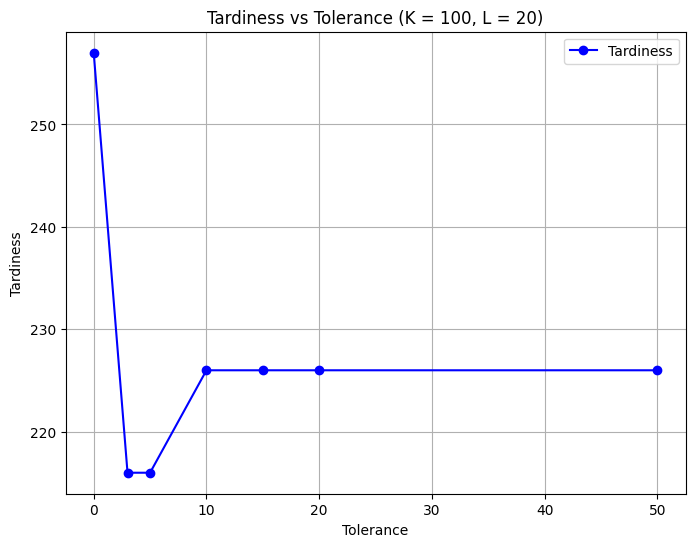

In [21]:
mean_tardiness_at_tolerance = []
std_deviation_tardiness_at_tolerance = []
for tolerance in tolerances:
    best_outcomes = []
    for _ in range(samples_to_test):
        _, best_tardiness = tabu_search(dag, p, d, tolerance=tolerance)
        best_outcomes.append(best_tardiness)
    mean_tardiness_at_tolerance.append(np.array(best_outcomes).mean())
    
plt.figure(figsize=(8, 6))
plt.plot(tolerances, mean_tardiness_at_tolerance, marker='o', color='b', label="Tardiness")
means = np.array(mean_tardiness_at_tolerance)

# Add labels and title
plt.xlabel('Tolerance')
plt.ylabel('Tardiness')
plt.title('Tardiness vs Tolerance (K = 100, L = 20)')

plt.grid(True)
plt.legend()
plt.show()

In [22]:
for tabu_len in tabu_list_lengths:
    _, best_tardiness = tabu_search(dag, p, d, tabu_list_length=tabu_len)
    # TODO: plot total tardiness vs tabu list length
    

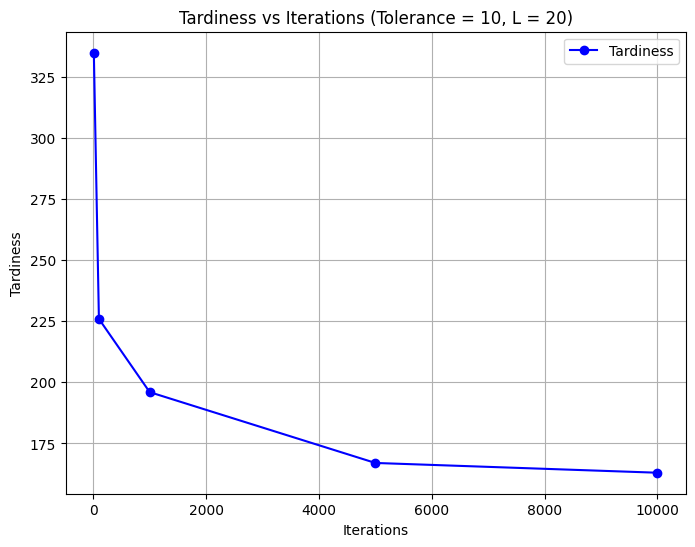

In [23]:
mean_tardiness_at_iter = []
std_deviation_tardiness_at_iter = []
for iter in num_iters:
    best_outcomes = []
    for _ in range(samples_to_test):
        _, best_tardiness = tabu_search(dag, p, d, num_iterations=iter)
        best_outcomes.append(best_tardiness)
    mean_tardiness_at_iter.append(np.array(best_outcomes).mean())

plt.figure(figsize=(8, 6))
plt.plot(num_iters, mean_tardiness_at_iter, marker='o', color='b', label="Tardiness")
means = np.array(mean_tardiness_at_iter)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Tardiness')
plt.title('Tardiness vs Iterations (Tolerance = 10, L = 20)')

plt.grid(True)
plt.legend()
plt.show()